In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import math
from sklearn.metrics import mean_absolute_error

In [2]:
hourly_df = pd.read_csv("bike+sharing+dataset/hour.csv")

### Data Inspection

In [3]:
hourly_df = hourly_df.rename(columns={'weathersit':'weather',
                       'yr':'year',
                       'mnth':'month',
                       'hr':'hour',
                       'hum':'humidity',
                       'cnt':'rental_count'})

In [4]:
hourly_df.isnull().sum()

instant         0
dteday          0
season          0
year            0
month           0
hour            0
holiday         0
weekday         0
workingday      0
weather         0
temp            0
atemp           0
humidity        0
windspeed       0
casual          0
registered      0
rental_count    0
dtype: int64

In [5]:
hourly_df.head()

instant      dteday  season  year  month  hour  holiday  weekday  \
0        1  2011-01-01       1     0      1     0        0        6   
1        2  2011-01-01       1     0      1     1        0        6   
2        3  2011-01-01       1     0      1     2        0        6   
3        4  2011-01-01       1     0      1     3        0        6   
4        5  2011-01-01       1     0      1     4        0        6   

   workingday  weather  temp   atemp  humidity  windspeed  casual  registered  \
0           0        1  0.24  0.2879      0.81        0.0       3          13   
1           0        1  0.22  0.2727      0.80        0.0       8          32   
2           0        1  0.22  0.2727      0.80        0.0       5          27   
3           0        1  0.24  0.2879      0.75        0.0       3          10   
4           0        1  0.24  0.2879      0.75        0.0       0           1   

   rental_count  
0            16  
1            40  
2            32  
3            13  
4             1

### Univariate plots

In [6]:
def plot_density(dataframe, column, title, xlabel, color='blue',ylim=None):
    """
    Plots a density plot for a specified column in a dataframe.

    Args:
    dataframe (pd.DataFrame): The dataframe containing the data.
    column (str): The name of the column in the dataframe to plot.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylim (tuple, optional): The y-axis limits. Default is None.
    """
    sns.kdeplot(dataframe[column], shade=True,color = color)
    plt.title(title)
    plt.xlabel(xlabel)
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()

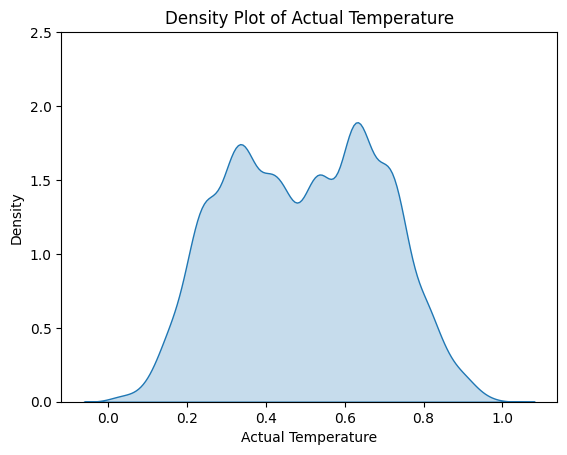

In [7]:
plot_density(hourly_df,'temp','Density Plot of Actual Temperature', 'Actual Temperature','#1f77b4', (0.0, 2.5))

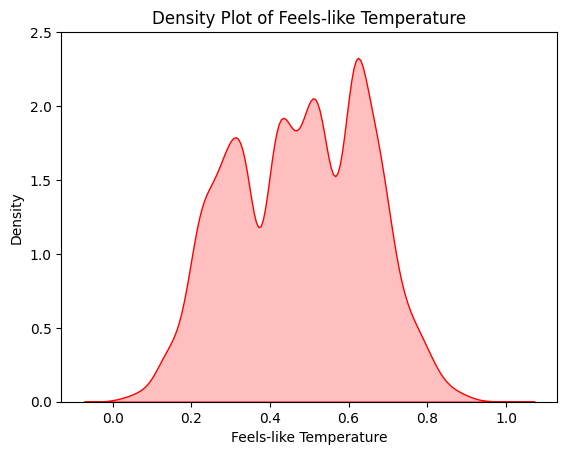

In [8]:
plot_density(hourly_df,'atemp','Density Plot of Feels-like Temperature', 'Feels-like Temperature','#FF0000',(0.0,2.5))

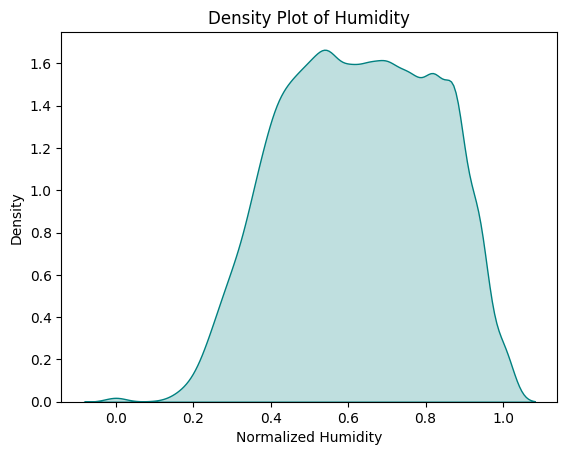

In [9]:
plot_density(hourly_df,'humidity','Density Plot of Humidity', 'Normalized Humidity','#008080')

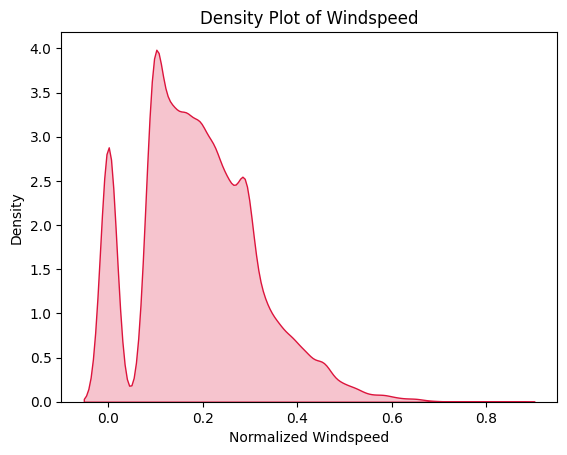

In [10]:
plot_density(hourly_df,'windspeed','Density Plot of Windspeed', 'Normalized Windspeed','#DC143C')

In [11]:
def plot_multi_boxplot(dataframe, columns, figsize=(10, 8)):
    """
    Creates a boxplot for multiple columns of a DataFrame.

    Args:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    columns (list): List of column names to be plotted.
    figsize (tuple, optional): Figure size. Default is (10, 8).
    """
    # Melt the DataFrame to long format
    data_long_format = dataframe[columns].melt(var_name='Variables', value_name='Values')

    # Create the boxplot
    plt.figure(figsize=figsize)
    sns.boxplot(data=data_long_format, x='Variables', y='Values')

    # Show the plot
    plt.show()


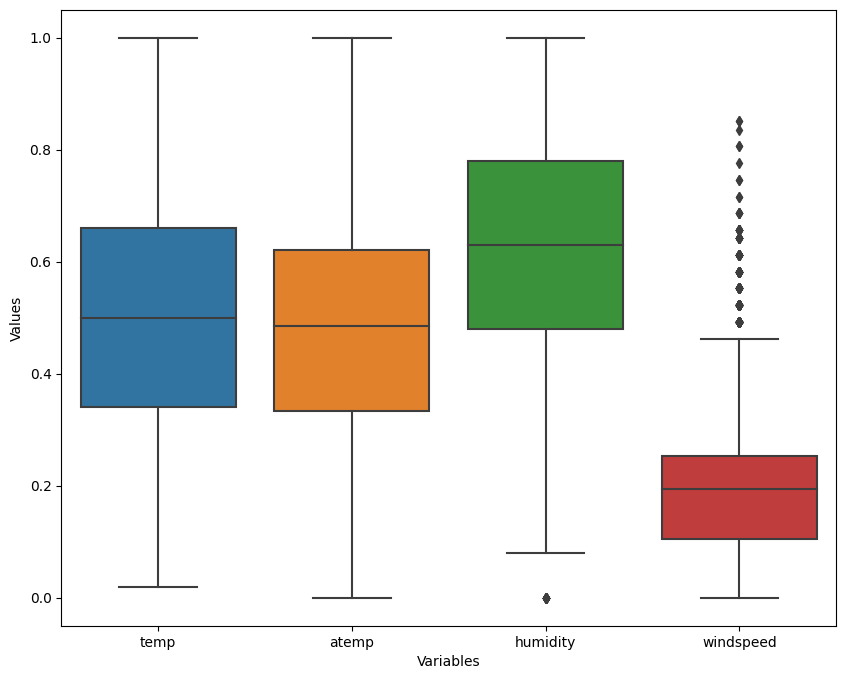

In [12]:
plot_multi_boxplot(hourly_df, ['temp', 'atemp', 'humidity', 'windspeed'])

### Multivariate Plots

In [13]:
def plot_line_chart(dataframe, x_col, y_col,y_axis_name,hue_col, title='', pal = "dark"):
    """
    Creates a line plot for a given DataFrame.

    Args:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    x_col (str): The name of the column to be used for the x-axis.
    y_col (str): The name of the column to be used for the y-axis.
    hue_col (str): The name of the column to color code (categorical variable).
    figsize (tuple, optional): The size of the figure. Default is (20, 5).
    title (str, optional): The title of the plot. Default is an empty string.
    """
    fig, ax = plt.subplots(figsize=(20, 5))
    palette = sns.color_palette(pal, len(dataframe[hue_col].unique()))
    sns.lineplot(data=dataframe, x=x_col, y=y_col, hue=hue_col, ax=ax, palette=palette)
    plt.ylabel(y_axis_name)
    ax.set(title=title)

    plt.show()


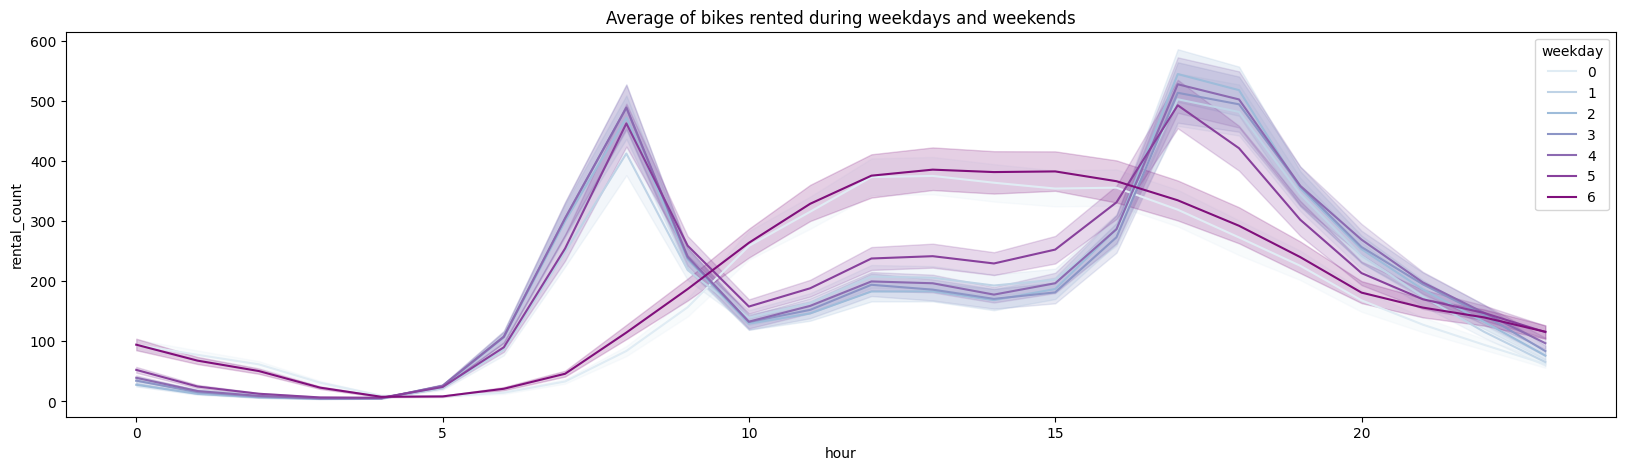

In [14]:
plot_line_chart(hourly_df, 'hour', 'rental_count','rental_count' ,'weekday',  'Average of bikes rented during weekdays and weekends', 'BuPu')

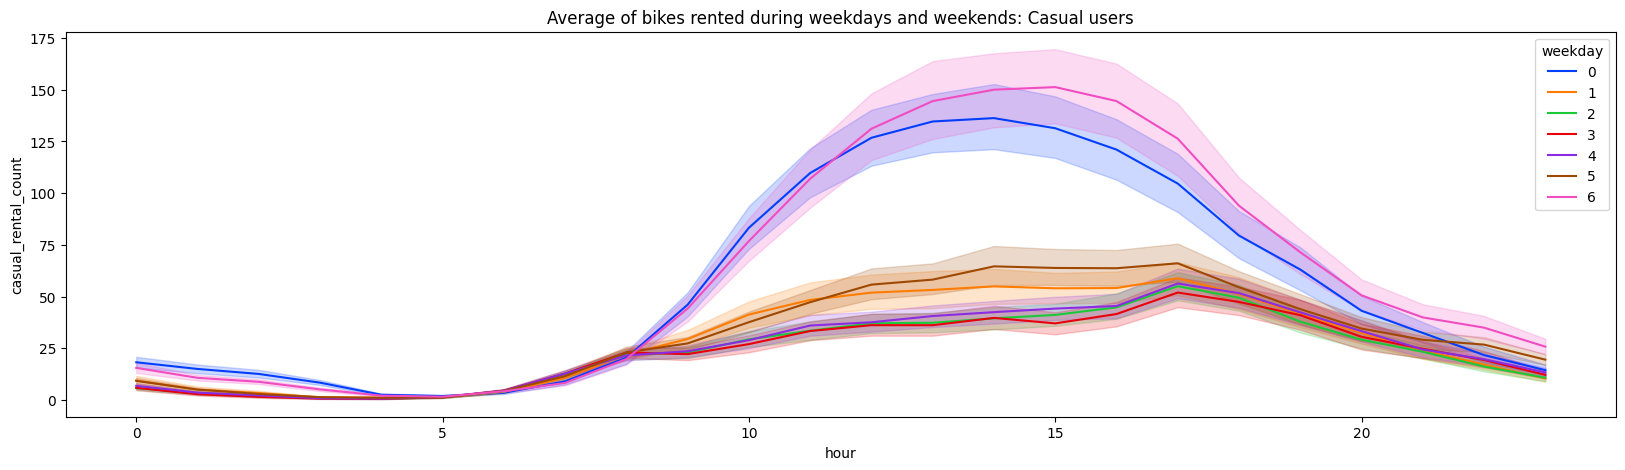

In [15]:
plot_line_chart(hourly_df, 'hour', 'casual', 'casual_rental_count','weekday',  'Average of bikes rented during weekdays and weekends: Casual users', 'bright')

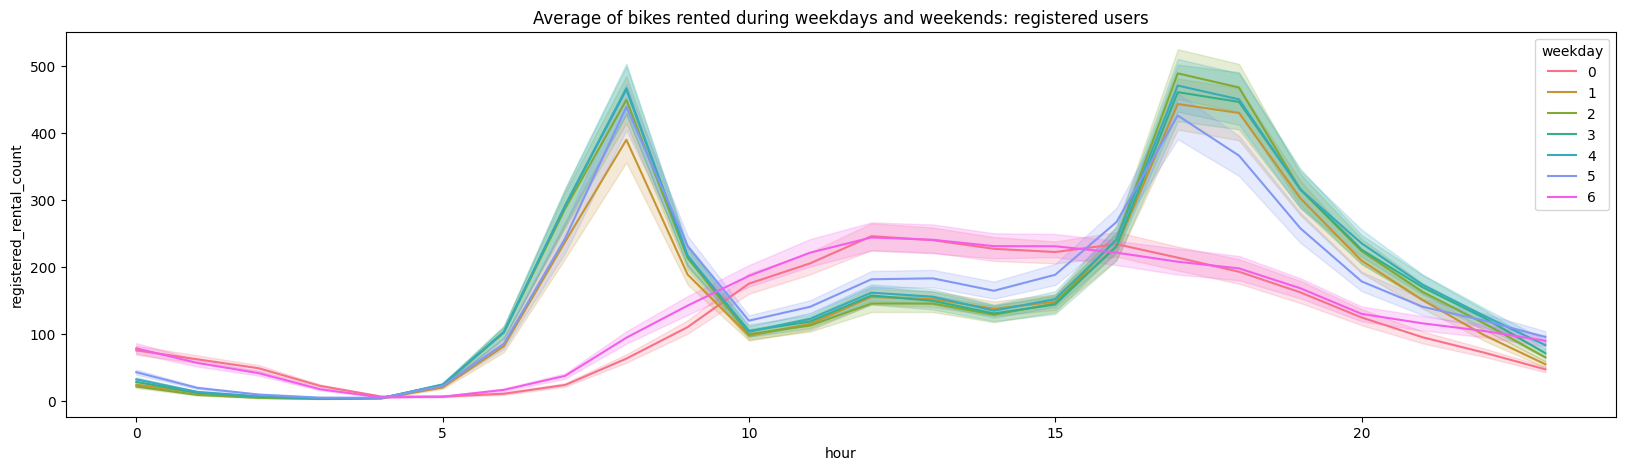

In [16]:
plot_line_chart(hourly_df, 'hour', 'registered','registered_rental_count', 'weekday',  'Average of bikes rented during weekdays and weekends: registered users', 'husl')

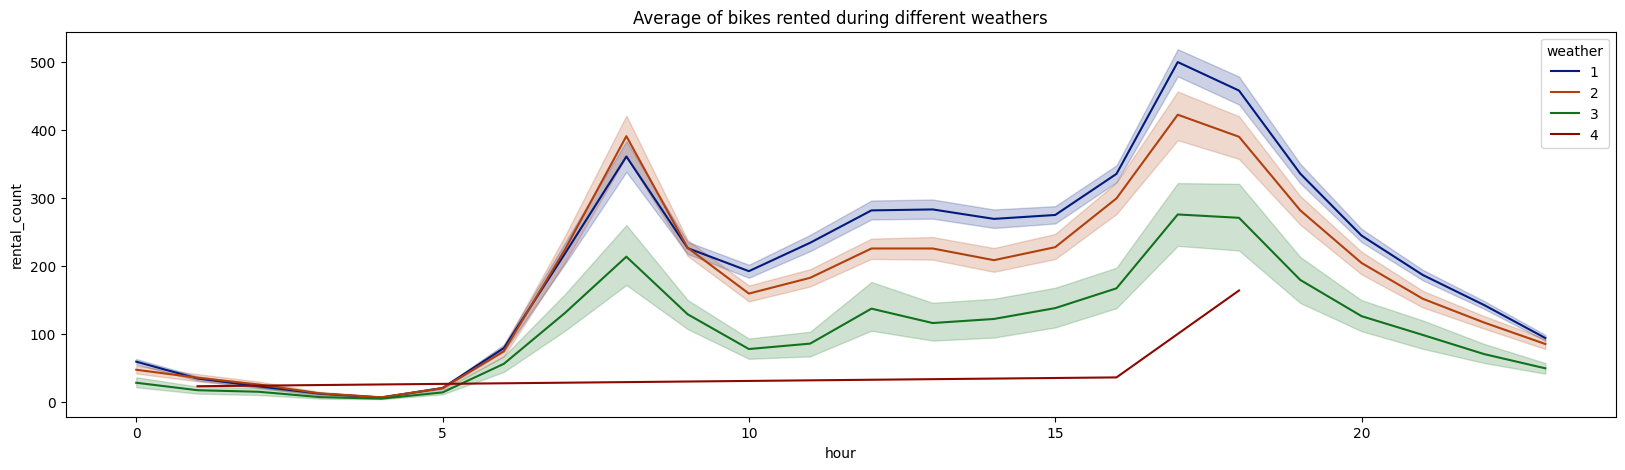

In [17]:
plot_line_chart(hourly_df, 'hour', 'rental_count','rental_count' ,'weather',  'Average of bikes rented during different weathers', 'dark')

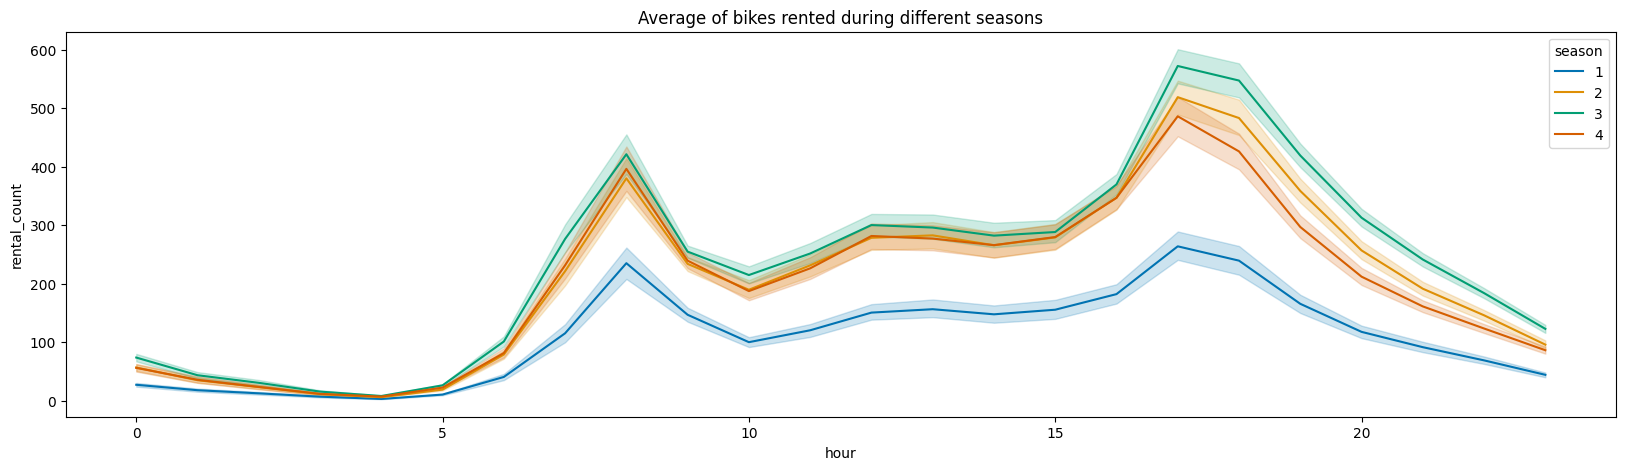

In [18]:
plot_line_chart(hourly_df, 'hour', 'rental_count', 'rental_count','season',  'Average of bikes rented during different seasons', 'colorblind')

In [19]:
def plot_correlation_heatmap(dataframe, columns, figsize=(12, 8), linewidths=.5, cmap="RdBu", annot=True, fmt="g"):
    """
    Plots a heatmap of the correlation matrix for the specified columns in a DataFrame.

    Args:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    columns (list): List of column names to compute the correlation matrix.
    figsize (tuple, optional): The size of the figure. Default is (12, 8).
    linewidths (float, optional): The width of the lines that will divide each cell. Default is 0.5.
    cmap (str, optional): Colormap recognized by matplotlib. Default is "RdBu".
    annot (bool, optional): Whether to annotate each cell with the numeric value. Default is True.
    fmt (str, optional): String formatting code for annotating cells. Default is "g".
    """
    # Calculate the correlation matrix
    corr = dataframe[columns].corr()

    # Create a figure
    fig = plt.figure(figsize=figsize)
    
    # Create the heatmap
    ax = sns.heatmap(corr, linewidths=linewidths, cmap=cmap, annot=annot, fmt=fmt)
    
    # Display the plot
    plt.show()


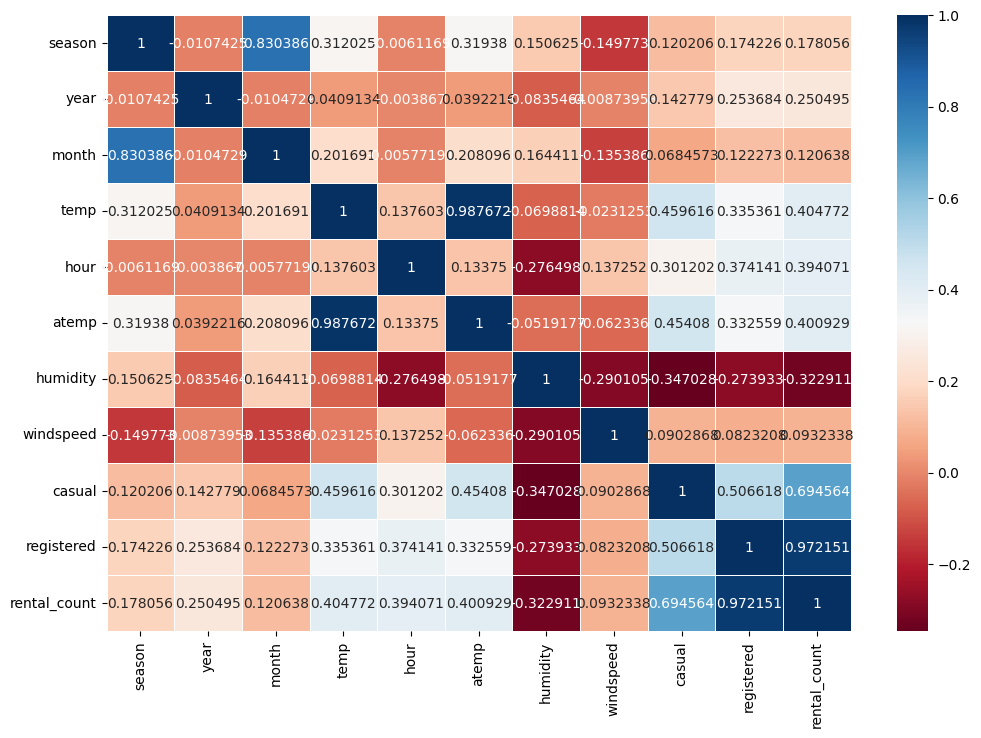

In [20]:
columns_to_plot = ['season','year','month','temp','hour', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'rental_count']
plot_correlation_heatmap(hourly_df, columns_to_plot)

In [21]:
def plot_faceted_scatter_threshold(dataframe, x_col, y_col, threshold, hue_col, palette, col_facet, col_wrap=4):
    """
    Plots a faceted scatter plot with a threshold line.

    Args:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    x_col (str): Column name for the x-axis.
    y_col (str): Column name for the y-axis.
    threshold (int or float): The threshold value for the hue separation.
    hue_col (str): Column name to be used for hue.
    palette (dict): Dictionary mapping hue levels to matplotlib colors.
    col_facet (str): Column name to be used for column faceting.
    col_wrap (int, optional): Number of columns for each row in the facet grid.
    """
    # Create the 'above_threshold' column based on the threshold
    dataframe[hue_col] = (dataframe[y_col] > threshold).astype(int)

    # Create the faceted scatter plot
    g = sns.relplot(
        data=dataframe, x=x_col, y=y_col,
        hue=hue_col, palette=palette,
        col=col_facet, col_wrap=col_wrap,
        kind="scatter",
        facet_kws={'margin_titles': True},
    )

    # Add a horizontal line at the threshold value
    g.map(plt.axhline, y=threshold, ls='--', c='orange')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

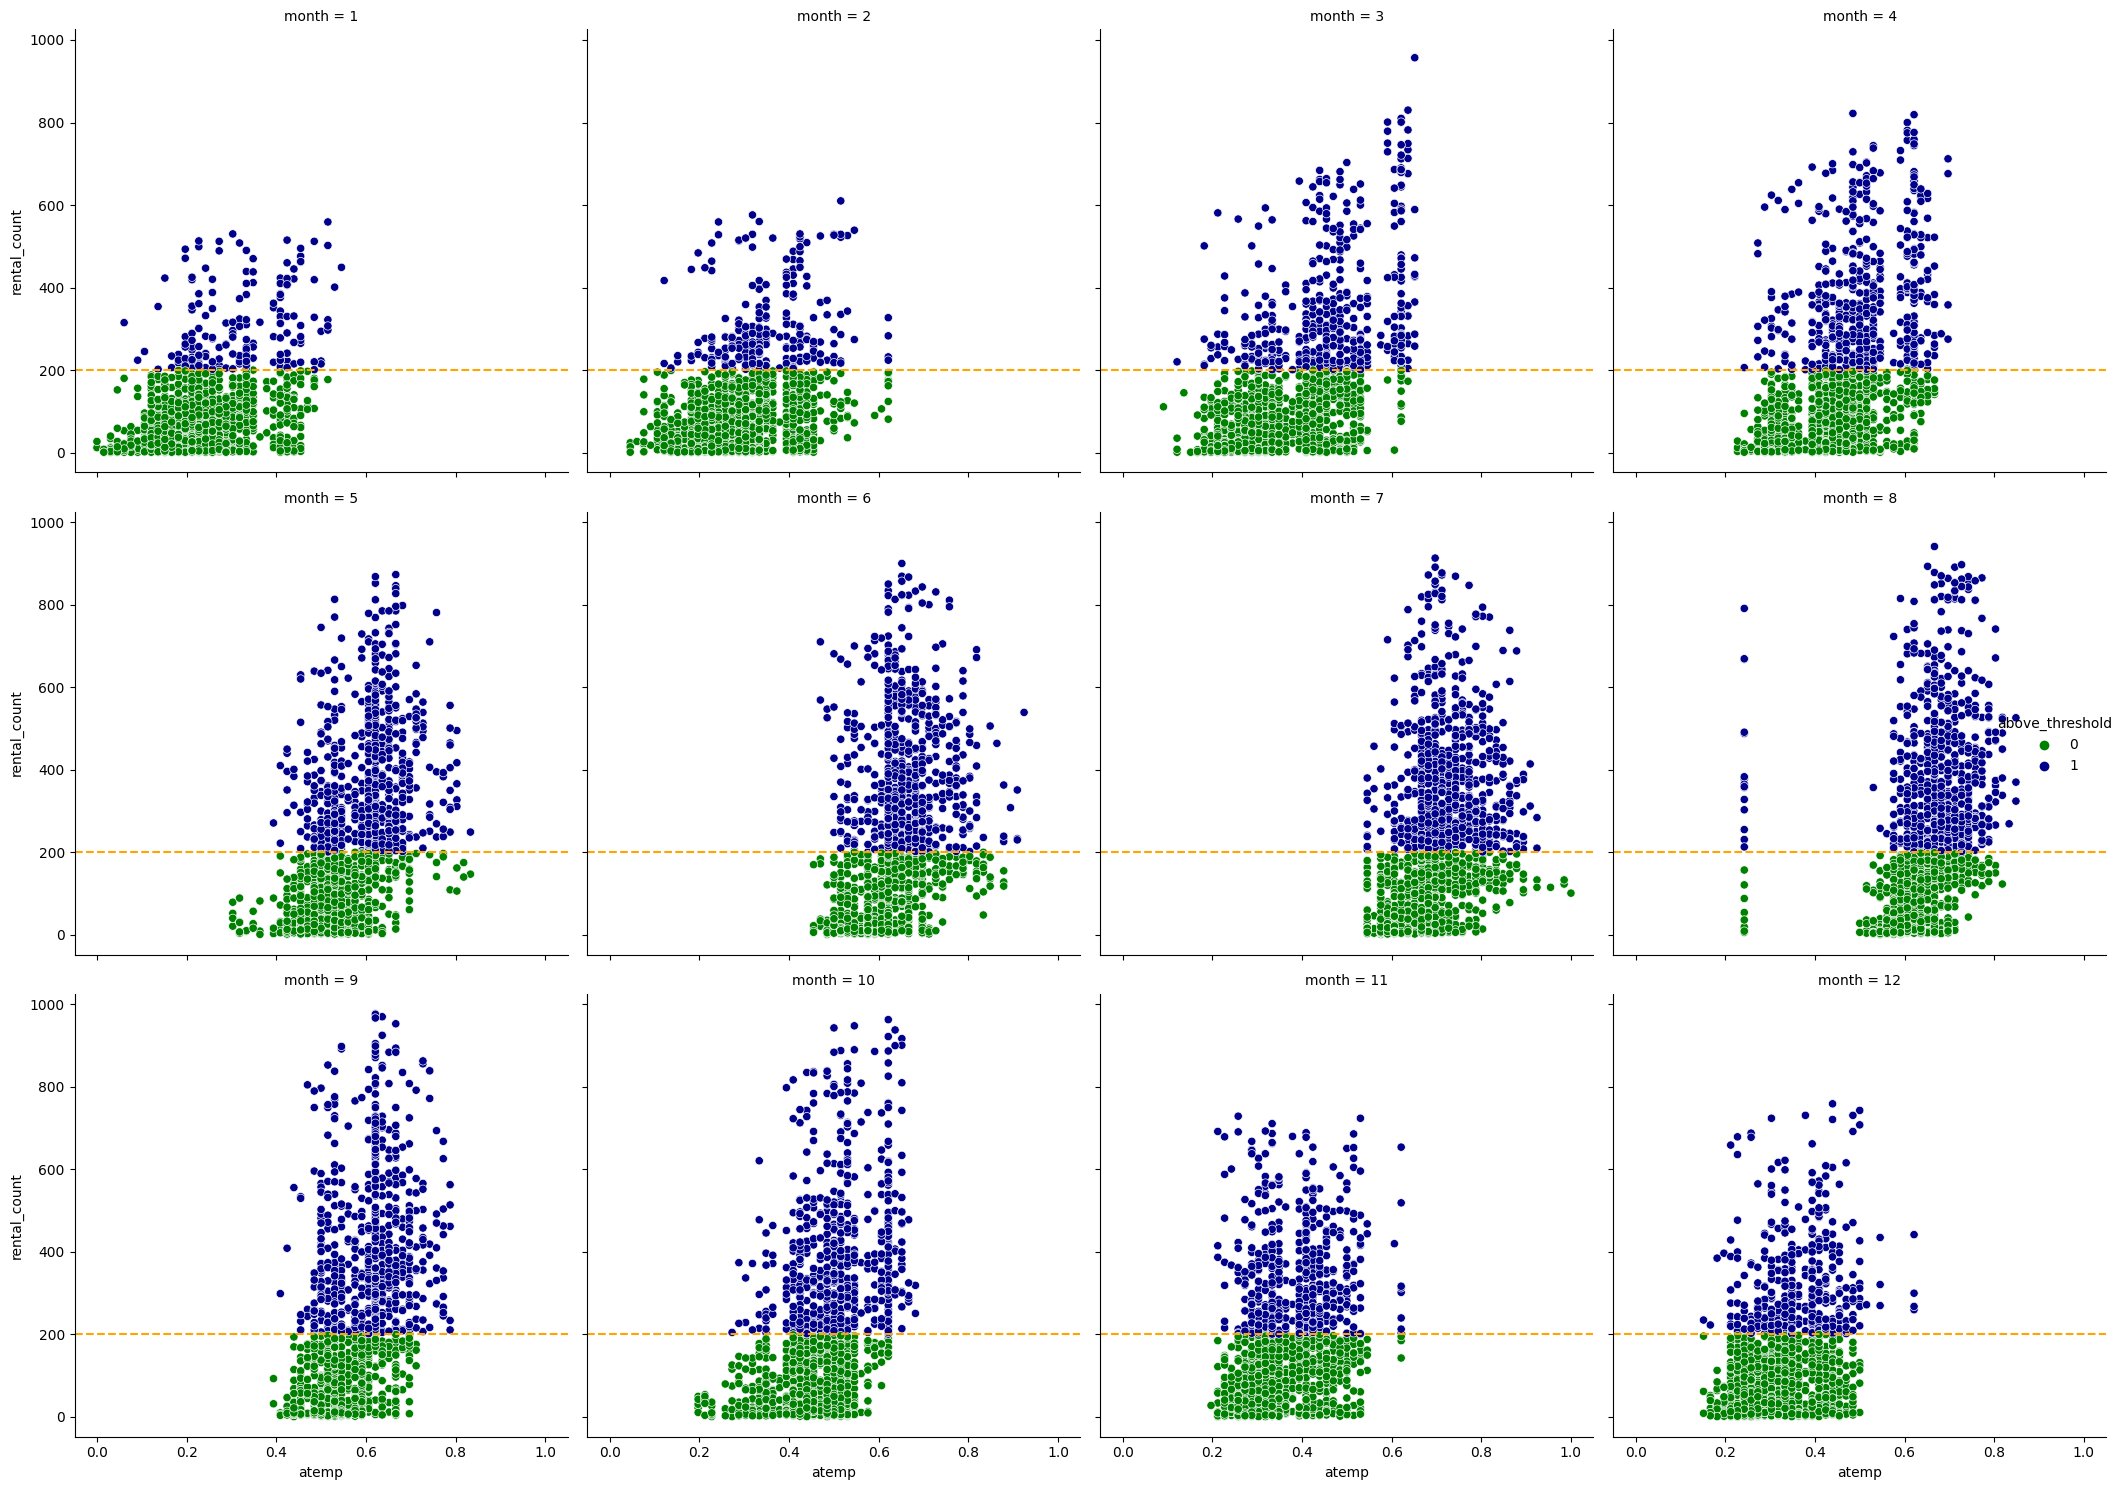

In [22]:
# Example usage:
plot_faceted_scatter_threshold(
    dataframe=hourly_df,
    x_col="atemp",
    y_col="rental_count",
    threshold=200,
    hue_col="above_threshold",
    palette={0: "green", 1: "darkblue"},
    col_facet="month"
)

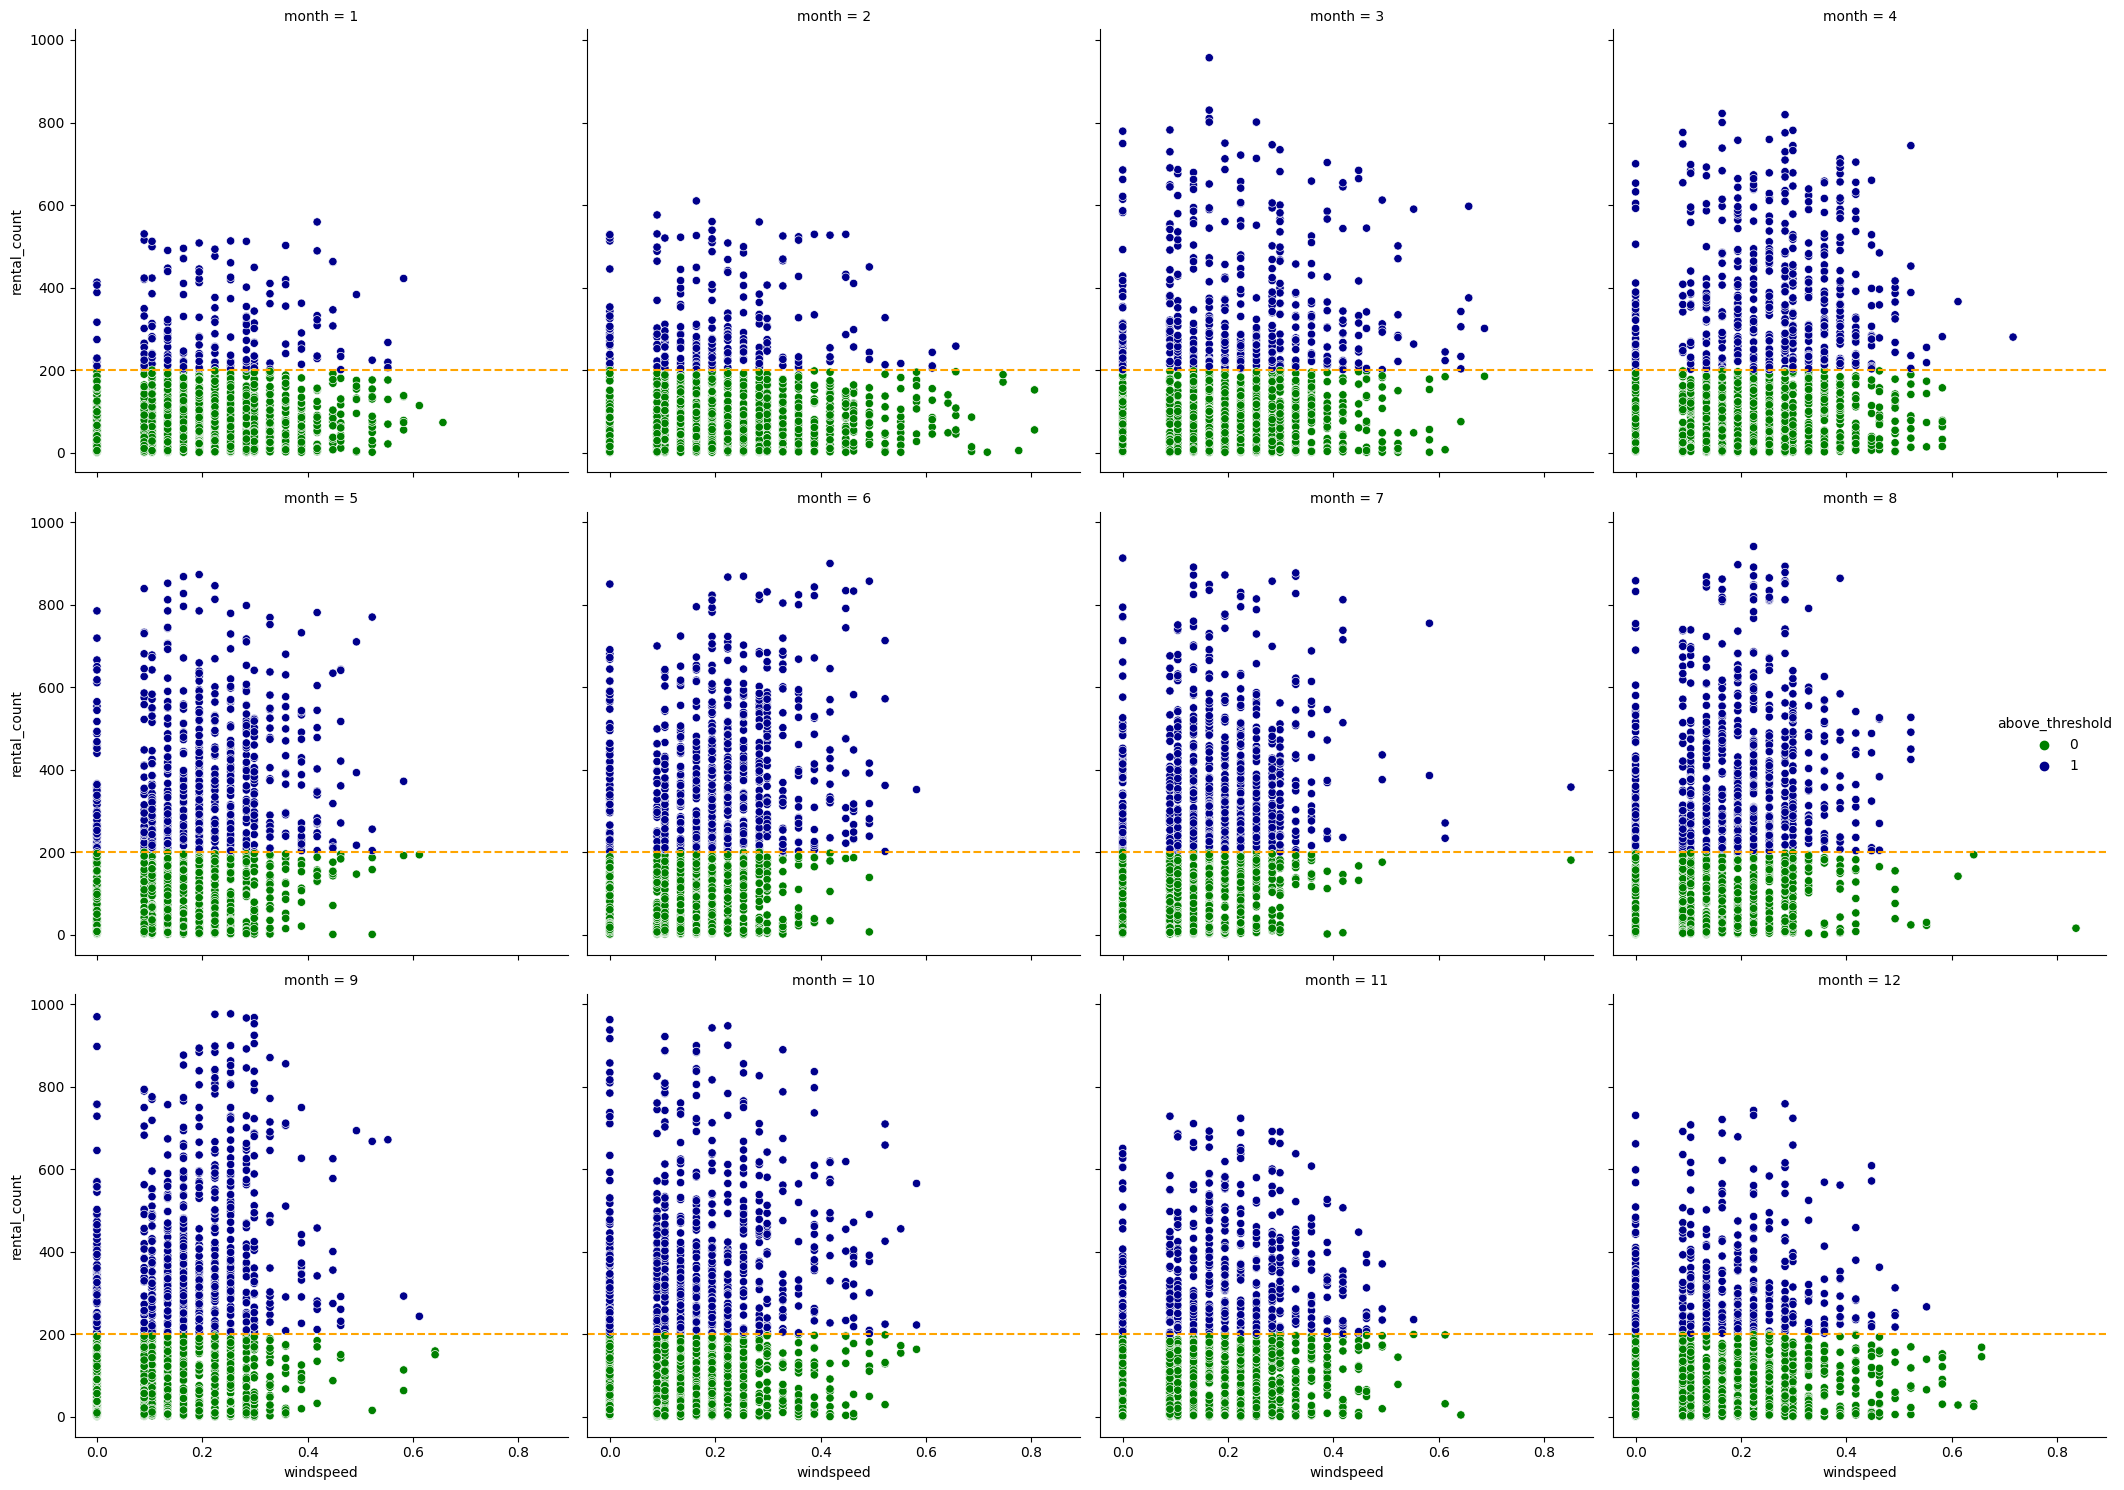

In [23]:
# Example usage:
plot_faceted_scatter_threshold(
    dataframe=hourly_df,
    x_col="windspeed",
    y_col="rental_count",
    threshold=200,
    hue_col="above_threshold",
    palette={0: "green", 1: "darkblue"},
    col_facet="month"
)

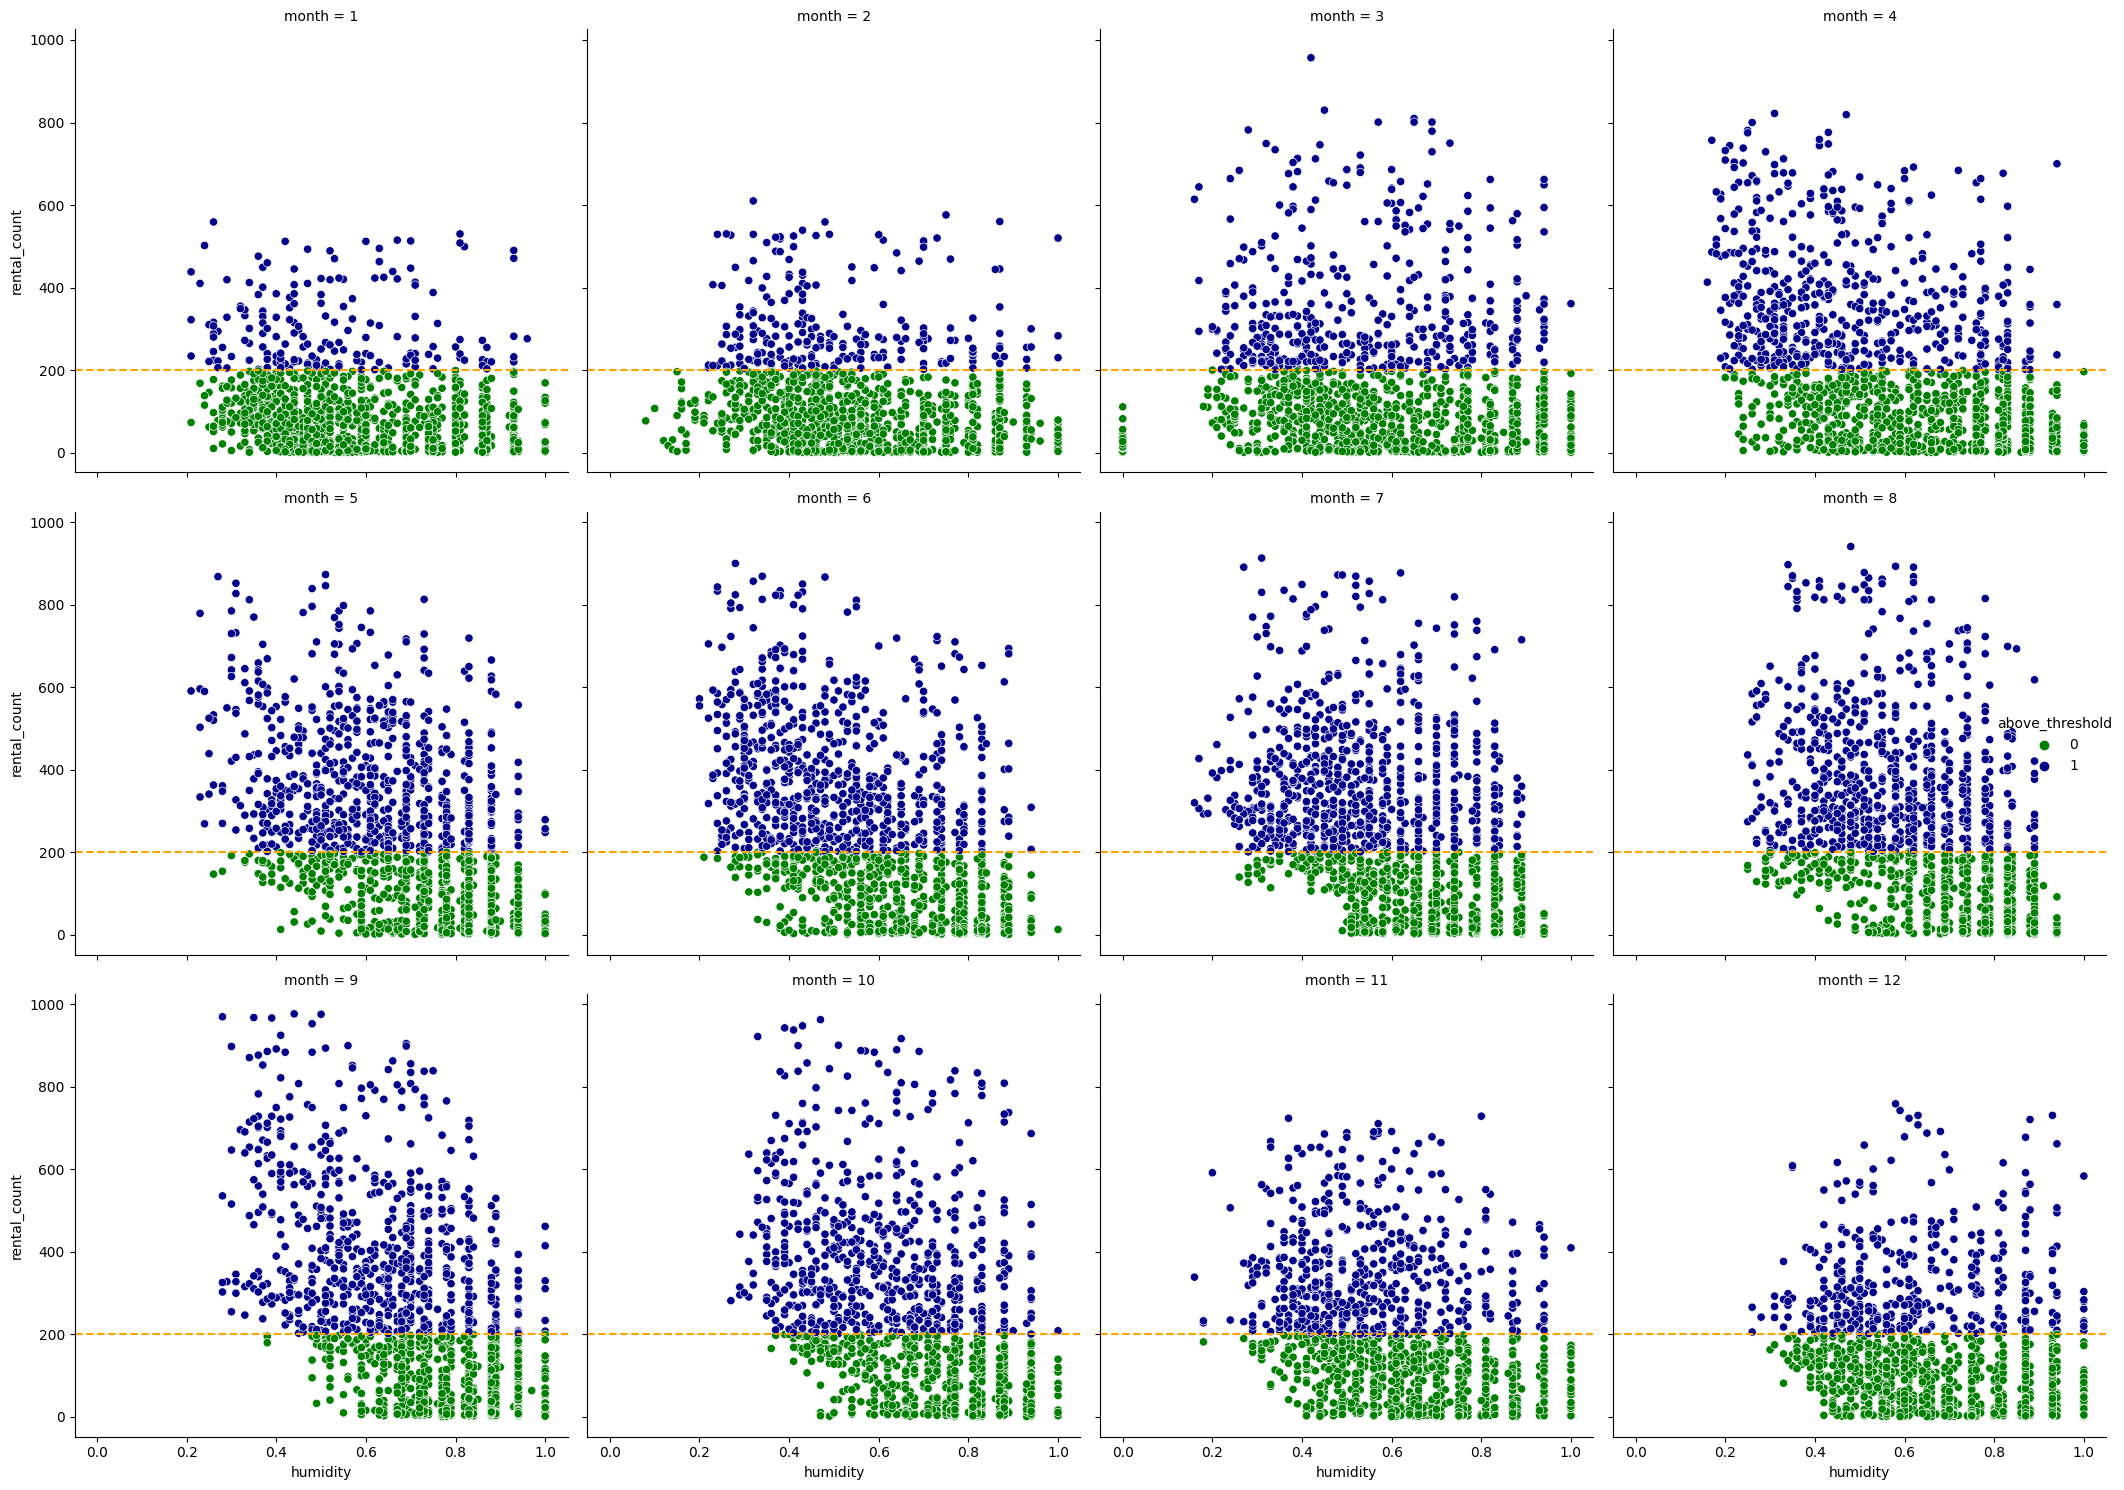

In [24]:
# Example usage:
plot_faceted_scatter_threshold(
    dataframe=hourly_df,
    x_col="humidity",
    y_col="rental_count",
    threshold=200,
    hue_col="above_threshold",
    palette={0: "green", 1: "darkblue"},
    col_facet="month"
)

### Model Building

In [25]:
def split_data(df, target, test_size=0.2, random_state=42):
    X = df.drop(target, axis=1)
    y = df[target]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [26]:
def train_lightgbm(X_train, y_train, X_test, y_test, params, num_round=650):
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])
    return bst

In [27]:
def predict_evaluate(bst, X_train, y_train, X_test, y_test):
    # Make predictions
    y_pred_test = bst.predict(X_test, num_iteration=bst.best_iteration)
    y_pred_train = bst.predict(X_train, num_iteration=bst.best_iteration)

    # Compute evaluation metrics
    mse_test = math.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    mse_train = math.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)

    # Print evaluation metrics
    print(f'Mean Squared Error Train: {mse_train:.2f}')
    print(f'Mean Squared Error Test: {mse_test:.2f}')
    print(f'R^2 Score Train: {r2_train:.2f}')
    print(f'R^2 Score Test: {r2_test:.2f}')
    print(f'Mean Absolute Error Train: {mae_train:.2f}')
    print(f'Mean Absolute Error Test: {mae_test:.2f}')

    return {
        'mse_train': mse_train,
        'mse_test': mse_test,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'mae_train': mae_train,
        'mae_test': mae_test
    },y_pred_test,y_pred_train






In [28]:
model_data = hourly_df.drop(['instant', 'dteday', 'temp', 'casual', 'registered', 'year', 'above_threshold'], axis=1)
X_train, X_test, y_train, y_test = split_data(model_data, 'rental_count')

# Define the parameters for the LightGBM model
params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'metric': {'l2', 'l1'}
}

# Train the model
bst = train_lightgbm(X_train, y_train, X_test, y_test, params)

# Evaluate the model
performance_metrics,y_pred_test,y_pred_train = predict_evaluate(bst, X_train, y_train, X_test, y_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 13903, number of used features: 10
[LightGBM] [Info] Start training from score 190.577070
Mean Squared Error Train: 62.32
Mean Squared Error Test: 65.09
R^2 Score Train: 0.88
R^2 Score Test: 0.87
Mean Absolute Error Train: 43.23
Mean Absolute Error Test: 44.64


In [29]:
def plot_actual_vs_predicted(actual, predicted, figsize=(12, 4), alpha=0.5):
    """

    Args:
    actual (array-like): The actual target values.
    predicted (array-like): The predicted values from the model.
    figsize (tuple, optional): Tuple denoting figure size. Default is (12, 4).
    alpha (float, optional): Alpha blending value for the scatter plot. Default is 0.5.
    """
    plt.figure(figsize=figsize)
    plt.scatter(actual, predicted, alpha=alpha)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted Test Data')
    plt.show()


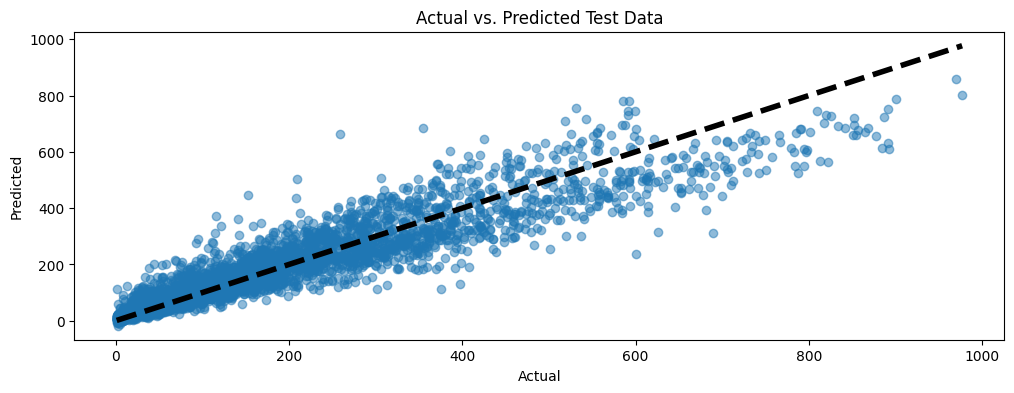

In [30]:
plot_actual_vs_predicted(y_test, y_pred_test)